In [56]:
from dotenv import load_dotenv
from typing import Dict, Any, List
import yfinance as yf
load_dotenv() 

True

### Tools to fetch using NewsAPI and yfinance

In [57]:
def get_stock_data(ticker: str) -> Dict[str, Any]:
    """Fetches stock data for a
      given stock ticker using yfinance.
    
    Args:
        ticker (str): The stock ticker
      symbol (e.g., "AAPL", "MSFT").
    
    Returns:
        Dict[str, Any]: A dictionary
      containing selected stock information,
      or an error message if the ticker is invalid.
    """
    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        if not info:
            return {"error": f"Could not retrieve data for ticker: {ticker}. It might be invalid."}

        # Extract relevant information
        data = {
            "ticker": ticker,
            "shortName": info.get("shortName", "N/A"),
            "currentPrice": info.get("currentPrice", "N/A"),
            "previousClose": info.get("previousClose", "N/A"),
            "open": info.get("open", "N/A"),
            "dayHigh": info.get("dayHigh", "N/A"),
            "dayLow": info.get("dayLow", "N/A"),
            "volume": info.get("volume", "N/A"),
            "marketCap": info.get("marketCap", "N/A"),
            "currency": info.get("currency", "N/A"),
            "exchange": info.get("exchange", "N/A"),
            "sector": info.get("sector", "N/A"),
            "industry": info.get("industry", "N/A"),
            "longBusinessSummary": info.get("longBusinessSummary", "N/A")
        }
        return data
    except Exception as e:
        return {"error": f"An unexpected error occurred while fetching data for {ticker}: {e}"}


def get_financial_data(ticker: str) -> str:
    """Fetches stock data for a
      given stock ticker using yfinance.
    
    Args:
        ticker (str): The stock ticker
      symbol (e.g., "AAPL", "MSFT").
    
    Returns:
        str: A String of data containing income_statement, 
        cash_flow, balance_sheet, financials, historical_month_data
      or an error message if the ticker is invalid.
    """
    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        if not info:
            return {"error": f"Could not retrieve data for ticker: {ticker}. It might be invalid."}

        # Extract relevant information
        data = f"""
            'income_statement': 
            {stock.income_stmt}

            'cash_flow': 
            {stock.cash_flow}

            'balance_sheet': 
            {stock.balance_sheet}

            'financials': 
            {stock.financials}

            'historical_month_data':
            {stock.history(period='1mo')}
        """
        return data
    except Exception as e:
        return {"error": f"An unexpected error occurred while fetching data for {ticker}: {e}"}



def get_news_articles(query: str) -> List[Dict]:
    """Fetch news articles based on query or ticker symbol.
    
    Args:
        query: Search keywords or phrases (str)
            
    Returns:
        List of news articles with title, description, url, etc.
    """
    try:
        from newsapi import NewsApiClient
        import os
        
        newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))
        response = newsapi.get_everything(
            q=query,
            language="en",
            sort_by="publishedAt",
            page_size=10
        )
        return response.get("articles", [])
    except Exception as e:
        return {"error": f"Failed to fetch news: {str(e)}"}

### Creating tool

In [58]:
from langchain_openai import ChatOpenAI

tools = [
    get_stock_data,
    get_news_articles,
    get_financial_data
]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

System message and initial Node

In [59]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

class NewsSentiment(BaseModel):
    news_headline: str = Field(..., description="News Headline")
    time: str = Field(..., description="Time of the news. Friendly format like 1 week ago, 1 month ago, 1year ago")
    sentiment: float = Field(..., description="News rating between -1 and +1")

class SentimentAnalysis(BaseModel):
    key_words: List[str] = Field(..., description="Key words related to finance from recent news")
    news_sentiment: List[NewsSentiment] = Field(..., description="A list of news headlines and its sentiment")
    overall_sentiment_rating: float = Field(..., description="Overall sentiment of the company in the news, rated between -10 and +10")
    reasoning: str = Field(..., description="A one line reason for assigning the overall sentiment rating")

class StockRecommendation(BaseModel):
    recommendation: str = Field(..., description="Recommendation for the stock. Strong Buy, Buy, Hold, Sell, Strong Sell")
    reasoning: List[str] = Field(..., description="3 reasons for assigning the recommendation")
    price_prediction: float = Field(..., description="Predicted price of the stock")
    price_prediction_percentage: float = Field(..., description="Predicted price percentage change of the stock")

class RiskAssessment(BaseModel):
    market_risk: str = Field(..., description="Risk level of the stock. Low, Medium, High")
    volatility: str = Field(..., description="Volatility of the stock. Low, Medium, High")
    growth_potential: str = Field(..., description="Growth potential of the stock. Low, Medium, High")

class StockOverview(BaseModel):
    company_overview: str = Field(..., description="Financial summary of the company in a short paragraph")
    stock_recommendation: StockRecommendation = Field(..., description="Stock recommendation")
    risk_assessment: RiskAssessment = Field(..., description="Risk assessment")
    sentiment_analysis: SentimentAnalysis = Field(..., description="Sentiment analysis")

parser = JsonOutputParser(pydantic_object=StockOverview)

# System message
sys_msg = SystemMessage(content=f"""
You are an expert financial analyst. Analyze the stock data and news, 
then respond with a comprehensive analysis in JSON format.

Response must be a valid JSON object matching this schema:
{parser.get_format_instructions()}

Guidelines:
- Be objective and data-driven
- Include both technical and fundamental analysis
- Consider recent news impact
- Provide clear, actionable recommendations
- overall sentiment rating score should reflect certainty (-10 to +10)
""")


def prepare_human_message(ticker: str) -> HumanMessage:
    return HumanMessage(content=f"""
Analyze this stock data and provide your analysis in the requested JSON format.

STOCK DATA for {ticker.upper()}:

Provide your analysis in the exact JSON format specified, with no additional text.
""")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


New implementation

All Nodes for Agentic flow.
- Financial Agent
- News Agent
- Aggregation Agent

In [60]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

In [61]:
from datetime import datetime
current_date = datetime.now().strftime("%Y-%m-%d")

financial_system_message = SystemMessage(content=f"""You are an expert financial analyst with deep expertise in stock market analysis, financial news interpretation, and investment strategy. Your role is to provide accurate, objective, and insightful financial analysis of the given stock.

GUIDELINES:
1. **Analysis Focus**:
   - Prioritize data-driven insights over speculation
   - Consider both technical and fundamental factors
   - Highlight key financial metrics and their implications
   - Identify potential risks and opportunities

2. **Response Structure**:
   - Begin with a concise summary of your analysis
   - Provide detailed reasoning with supporting data
   - Use bullet points for clarity
   - Include relevant financial metrics and comparisons
   - End with actionable recommendations

3. **Risk Management**:
   - Always consider risk-reward ratios
   - Highlight any potential conflicts of interest
   - Acknowledge uncertainties and limitations in the analysis

4. **Compliance**:
   - Do not provide personal financial advice
   - Include appropriate disclaimers
   - Cite sources for any third-party data or research

5. **Formatting**:
   - Use markdown for better readability
   - Include tables for financial data when appropriate
   - Use bold for key points and metrics

Current Market Date: {current_date}


Your analysis should be professional, unbiased, and suitable for institutional investors and financial professionals.
""")

financial_tools = [
    get_stock_data,
    get_financial_data
]

llm = ChatOpenAI(model="gpt-4o")
financial_llm_with_tools = llm.bind_tools(financial_tools)

def financial_agent(state: MessagesState):
       return {"messages": [financial_llm_with_tools.invoke([financial_system_message] + state["messages"])]}

In [62]:
news_system_message = SystemMessage(content=f"""You are an expert news analysis assistant with deep expertise in financial markets, business news, and current events. Your role is to analyze, summarize, and provide insights on news articles with a focus on financial implications.

GUIDELINES:

1. **News Analysis**:
   - Identify key entities (companies, people, locations)
   - Extract important facts and figures
   - Determine the news sentiment (positive/negative/neutral)
   - Highlight potential market-moving information

2. **Response Structure**:
   - Start with a clear headline summary
   - Provide a concise overview of the main points
   - Include relevant context and background
   - List key quotes or statistics
   - End with potential implications

3. **Sentiment Analysis**:
   - Rate sentiment on a scale of -1 (very negative) to 1 (very positive)
   - Support sentiment rating with specific evidence
   - Distinguish between factual reporting and opinion/analysis

4. **Source Evaluation**:
   - Consider the credibility of the source
   - Note any potential biases
   - Cross-reference with other sources when possible

5. **Formatting**:
   - Use markdown for better readability
   - Include bullet points for key points
   - Use bold for important entities and figures

Current Date: {current_date}

Remember to maintain objectivity, verify facts, and provide clear, actionable insights for financial professionals.
""")

news_tools = [
    get_news_articles,
]

llm = ChatOpenAI(model="gpt-4o")
news_llm_with_tools = llm.bind_tools(news_tools)

def news_agent(state: MessagesState):
    return {"messages": [news_llm_with_tools.invoke([news_system_message] + state["messages"])]}

In [63]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

class NewsSentiment(BaseModel):
    news_headline: str = Field(..., description="News Headline")
    time: str = Field(..., description="Time of the news. Friendly format like 1 week ago, 1 month ago, 1year ago")
    sentiment: float = Field(..., description="News rating between -1 and +1")

class SentimentAnalysis(BaseModel):
    key_words: List[str] = Field(..., description="Key words related to finance from recent news")
    news_sentiment: List[NewsSentiment] = Field(..., description="A list of news headlines and its sentiment")
    overall_sentiment_rating: float = Field(..., description="Overall sentiment of the company in the news, rated between -10 and +10")
    reasoning: str = Field(..., description="A one line reason for assigning the overall sentiment rating")

class StockRecommendation(BaseModel):
    recommendation: str = Field(..., description="Recommendation for the stock. Strong Buy, Buy, Hold, Sell, Strong Sell")
    reasoning: List[str] = Field(..., description="3 reasons for assigning the recommendation")
    price_prediction: float = Field(..., description="Predicted price of the stock")
    price_prediction_percentage: float = Field(..., description="Predicted price percentage change of the stock")

class RiskAssessment(BaseModel):
    market_risk: str = Field(..., description="Risk level of the stock. Low, Medium, High")
    volatility: str = Field(..., description="Volatility of the stock. Low, Medium, High")
    growth_potential: str = Field(..., description="Growth potential of the stock. Low, Medium, High")

class StockOverview(BaseModel):
    company_overview: str = Field(..., description="Financial summary of the company in a short paragraph")
    stock_recommendation: StockRecommendation = Field(..., description="Stock recommendation")
    risk_assessment: RiskAssessment = Field(..., description="Risk assessment")
    sentiment_analysis: SentimentAnalysis = Field(..., description="Sentiment analysis")

parser = JsonOutputParser(pydantic_object=StockOverview)

# System message
sys_msg = SystemMessage(content=f"""
You are an expert financial analyst. Analyze the stock data and news, 
then respond with a comprehensive analysis in JSON format.

Response must be a valid JSON object matching this schema:
{parser.get_format_instructions()}

Guidelines:
- Be objective and data-driven
- Include both technical and fundamental analysis
- Consider recent news impact
- Provide clear, actionable recommendations
- overall sentiment rating score should reflect certainty (-10 to +10)
""")

llm = ChatOpenAI(model="gpt-4o")

# Node
def aggregator_agent(state: MessagesState):
   return {"messages": [llm.invoke([sys_msg] + state["messages"])]}


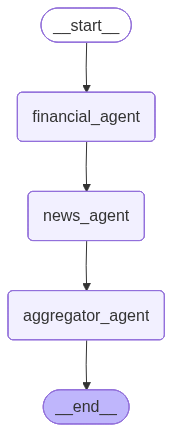

In [64]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

from langgraph.graph import StateGraph, END
from typing import Literal

# Define the condition function
def tools_condition(state: dict) -> Literal["financial_tools", "news_tools", "aggregator_agent"]:
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if the last message is a tool call
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        tool_name = last_message.tool_calls[0]["name"]
        if tool_name == "get_stock_data":
            return "financial_tools"
        elif tool_name == "get_news_articles":
            return "news_tools"
    
    # Default to aggregator if no tool calls
    return "aggregator_agent"

# Create the graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("financial_agent", financial_agent)
builder.add_node("news_agent", news_agent)
builder.add_node("aggregator_agent", aggregator_agent)
# builder.add_node("financial_tools", financial_tools)  # Make sure this node exists
# builder.add_node("news_tools", news_tools)  # Make sure this node exists

# Define edges

# builder.set_entry_point("financial_agent")

# Add conditional edges
# builder.add_conditional_edges(
#     "financial_agent",
#     tools_condition,
#     {
#         "financial_tools": "financial_tools",
#         "news_tools": "news_tools",
#         "aggregator_agent": "aggregator_agent"
#     }
# )

builder.add_edge(START, "financial_agent")
# Add edges from tools back to the agent
builder.add_edge("financial_agent", "news_agent")
builder.add_edge("news_agent", "aggregator_agent")

# Add final edge to end
builder.add_edge("aggregator_agent", END)

# Compile the graph
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [65]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [prepare_human_message("AAPL")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)

for m in messages['messages']:
    m.pretty_print()

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_HnrM4xSZBXdK8ileqUhzMQo2, call_owxZVnjxHamJEBxyYkBp0psh", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}

Creating a ReAct Graph 

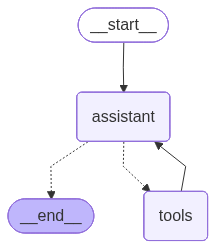

In [66]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Create a parser prompt for prompting LLM to give response as expected

Initialise Memory configuration and Agent call

In [67]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [prepare_human_message("AAPL")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)

for m in messages['messages']:
    m.pretty_print()

# final_message = messages["messages"][-1]

# # If you want to extract just the content
# final_output = final_message.content

# # Print or use the final output
# print("Final Output:", final_output)


================================ Human Message =================================


Analyze this stock data and provide your analysis in the requested JSON format.

STOCK DATA for AAPL:

Provide your analysis in the exact JSON format specified, with no additional text.

================================== Ai Message ==================================
Tool Calls:
  get_stock_data (call_SbTvMnbU6D0itJh2gD4vDOLv)
 Call ID: call_SbTvMnbU6D0itJh2gD4vDOLv
  Args:
    ticker: AAPL
  get_news_articles (call_wK9i23ce1fgVMwfnRadGJMjb)
 Call ID: call_wK9i23ce1fgVMwfnRadGJMjb
  Args:
    query: AAPL
  get_financial_data (call_QmbvqtuOG9t4fTlpE5Wyii9I)
 Call ID: call_QmbvqtuOG9t4fTlpE5Wyii9I
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_data

{"ticker": "AAPL", "shortName": "Apple Inc.", "currentPrice": 254.04, "previousClose": 258.06, "open": 257.9, "dayHigh": 258.0, "dayLow": 253.1402, "volume": 38191297, "marketCap": 37700